In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

#from IPython.display import display, Latex, clear_output

In [2]:
# WebbPSF
import pynrc, webbpsf, os

# Interpolation and extrapolation
from scipy.interpolate import griddata, RegularGridInterpolator
from scipy.ndimage import rotate

# pySIAF stuff for plotting
from pysiaf.siaf import Siaf
from pysiaf.siaf import plot_main_apertures

# Astropy Tables and FITS
from astropy.table import Table, join
from astropy.io import fits
from astropy.io import ascii

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
# Directory and file information
outdir = pynrc.conf.path + 'opd_mod/'

# Read in measured SI Zernike data
data_dir = webbpsf.utils.get_webbpsf_data_path() + '/'
zernike_file = outdir + 'si_zernikes_coron_wfe.csv'

# Read in table data
ztable_full = ascii.read(zernike_file)  
ztable_full.rename_column('\ufeffinstrument', 'instrument')

# Zernike names
keys = np.array(ztable_full.keys())
ind_z = ['Zernike' in k for k in keys]
zkeys = keys[ind_z]

# Convert .csv to .fits Table

In [7]:
zfile_fits = zernike_file[0:-4] + '.fits'
ztable_full.write(zfile_fits, format='fits')

In [8]:
tbl_wfe = Table.read(data_dir + 'si_zernikes_isim_cv3.fits')
tbl_coron = Table.read(zernike_file)

In [9]:
tbl_wfe

instrument,field_point_name,V2,V3,PIXEL_X,PIXEL_Y,DETECTOR,WFE_RMS,Zernike_1,Zernike_2,Zernike_3,Zernike_4,Zernike_5,Zernike_6,Zernike_7,Zernike_8,Zernike_9,Zernike_10,Zernike_11,Zernike_12,Zernike_13,Zernike_14,Zernike_15,Zernike_16,Zernike_17,Zernike_18,Zernike_19,Zernike_20,Zernike_21,Zernike_22,Zernike_23,Zernike_24,Zernike_25,Zernike_26,Zernike_27,Zernike_28,Zernike_29,Zernike_30,Zernike_31,Zernike_32,Zernike_33,Zernike_34,Zernike_35,Zernike_36,origin,comments
,,arcmin,arcmin,pix,pix,,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,m,,
bytes10,bytes10,float64,float64,float64,float64,bytes11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes80,bytes240
Guider1,ASPAG1A,4.243813001,-12.204481009,1711.0,1497.0,FGS1_1,2.777925434872053e-08,2.1588991307404575e-09,3.0297333747465348e-09,9.990501956410384e-10,1.199701389475119e-08,1.2168427794656664e-08,-3.5664944969981764e-09,2.017309406736293e-09,8.780562597373421e-09,3.2944179756947098e-09,1.190142399663702e-08,5.114966522662449e-09,-1.514419166698998e-09,2.274620160271143e-09,-1.3405283964280843e-08,-4.875639483147028e-09,-3.350583827906116e-10,1.0401901448432255e-09,-7.3657696307605215e-09,-3.78191222856489e-09,-8.144748776917959e-10,-2.790845111344189e-09,6.9812805050685904e-09,5.086871718483054e-09,1.5429133501686715e-09,-3.0525679543588715e-10,-5.147004134023554e-09,-9.965849071981848e-10,-2.7616239690617165e-09,2.8550913288910253e-09,-2.60545879599318e-11,-4.909398995559523e-09,-2.240015377824439e-10,1.8591046586556508e-09,-1.4456435007222208e-09,-1.326176656920742e-09,-1.1451565237369654e-09,ISIM CV2 phase retrieval: Guider1/Guider1_ASPAG1A_Tricontagon_2.1um.fits,
Guider1,ASPAI7,4.098480105,-12.106938738,1588.005533,1416.672665,FGS1_1,2.229854171157994e-08,6.883642115358989e-10,1.6646576542782795e-09,2.7826450994759536e-09,-9.384732815671355e-10,1.489500225687883e-09,-1.0452444233832811e-08,7.58594723928376e-09,3.852862303410115e-09,5.291105992305623e-09,7.074938689705434e-09,6.062021055999103e-09,2.0987086694934101e-10,9.407960595457574e-10,-8.249300139827171e-09,-3.730033191035644e-09,7.857592583978706e-10,3.240344128108386e-10,-2.3659760059886897e-09,-6.310079742884713e-09,2.484468412364056e-09,-2.8665830979847643e-09,6.460929414761501e-09,5.605448026696179e-09,8.265880362185475e-10,3.88791076239223e-09,-3.3444095522799773e-09,-7.35954039739629e-10,-1.1216835985155513e-09,1.6127387751382922e-09,2.1976728387207173e-10,-3.859353136107549e-09,5.401687107749045e-10,3.2738866480693397e-09,-1.8886928528518997e-09,-1.8964440197640023e-09,-7.721843196282375e-10,ISIM CV2 phase retrieval: Guider1/Guider1_ASPAI7_Tricontagon_2.1um.fits,
Guider1,ASPAI8,4.271962184,-12.105763815,1738.041693,1413.350532,FGS1_1,3.3625488758495295e-08,3.827898857269974e-09,2.7656794047047495e-09,2.1134496370034802e-10,2.6840819065774534e-08,-9.505027332645373e-09,7.403295829827566e-10,2.4595057046339206e-09,9.485107639698239e-09,4.2457855658305486e-09,1.4880450892134903e-08,2.9767248620592094e-10,-1.395179636785255e-09,1.0614311458246513e-09,-6.139687590926382e-09,-3.5934563856353293e-09,-3.275722087785725e-09,-2.2027045716849493e-09,-4.7928191372859334e-09,-3.740656419389296e-09,-6.29967526811773e-10,2.617668148298865e-10,4.6738137947626054e-09,4.044632394544786e-09,3.1624871751208034e-09,2.7459691330224797e-09,-1.207692037657669e-09,-8.01798624881014e-10,-5.117924580229427e-09,3.149105715519253e-09,8.712749383935974e-10,-2.723516591803428e-09,-1.3563667172346852e-09,1.5209937577930304e-09,-1.5922834112517824e-09,-8.491961453842397e-10,-1.042051515221302e-09,ISIM CV2 phase retrieval: Guider1/Guider1_ASPAI8_Tricontagon_2.1um.fits,
Guider1,ASPAI9,4.273972465,-12.279071723,1734.902689,1559.308714,FGS1_1,4.675765840826089e-08,5.24856

In [10]:
tbl_coron

﻿instrument,field_point_name,V2,V3,PIXEL_X,PIXEL_Y,DETECTOR,WFE_RMS,Zernike_1,Zernike_2,Zernike_3,Zernike_4,Zernike_5,Zernike_6,Zernike_7,Zernike_8,Zernike_9,Zernike_10,Zernike_11,Zernike_12,Zernike_13,Zernike_14,Zernike_15,Zernike_16,Zernike_17,Zernike_18,Zernike_19,Zernike_20,Zernike_21,Zernike_22,Zernike_23,Zernike_24,Zernike_25,Zernike_26,Zernike_27,Zernike_28,Zernike_29,Zernike_30,Zernike_31,Zernike_32,Zernike_33,Zernike_34,Zernike_35,Zernike_36,origin,comments
str9,str8,float64,float64,int64,int64,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str11,str54
NIRCamLWA,ISIM26,0.869,-8.777,535,-231,NIRCAMALW,2.51e-07,-1.4e-08,-8.83e-10,1.52e-09,2.22e-07,-1.01e-08,-4.91e-08,1.22e-07,-1.22e-09,-1.22e-09,3.87e-10,1.39e-09,-1.13e-09,-1.58e-09,3.17e-11,4.41e-10,4.82e-10,-6.2e-09,5.98e-10,-2.73e-10,4.53e-11,1.42e-11,-9.53e-09,-3.96e-10,-3.75e-10,-7.74e-11,-2.78e-12,5.17e-13,-1.65e-12,1.02e-10,-1.08e-10,3.65e-11,-7.62e-11,9.69e-14,-1.62e-13,-6.14e-13,-1.94e-13,Zemax Model,--
NIRCamLWA,ISIM27,0.453,-8.389,140,127,NIRCAMALW,2.17e-07,-1.15e-08,-4.09e-10,2.34e-09,1.76e-07,-1.86e-08,-5.9e-08,1.2e-07,-4.35e-09,-1.13e-09,-5.56e-11,1.82e-09,8.81e-10,-2.37e-09,-2.83e-10,1.11e-10,-1.01e-09,-6.04e-09,4.78e-10,2.81e-10,-1.19e-11,2.8e-11,-9.62e-09,-6e-10,-2.97e-11,-1.59e-11,5.38e-11,9.37e-13,-2.58e-13,6.13e-11,-2.61e-10,-3.37e-11,-5.31e-11,-1.62e-13,3.88e-13,-4.85e-13,-2.91e-13,Zemax Model,--
NIRCamLWA,ISIM28,1.598,-9.219,1218,-639,NIRCAMALW,2.96e-07,-1.62e-08,-2.57e-09,2.73e-09,3.21e-07,-2.31e-08,-3.68e-08,1.27e-07,4.18e-09,-3.07e-09,-3.72e-11,1.92e-09,-4.84e-09,2.29e-09,9.48e-10,-7.44e-11,2.74e-09,-5.21e-09,-1.19e-10,-1.13e-09,-1.9e-11,-9.53e-12,-9.38e-09,1.24e-10,-7.65e-10,1.97e-11,-5.51e-11,1.07e-12,-5.87e-11,1.87e-10,9.01e-11,5.35e-11,1.14e-11,5.34e-11,1.23e-12,-2.07e-11,-9.69e-14,Zemax Model,--
NIRCamLWA,ISIM29,2.404,-8.077,1984,421,NIRCAMALW,1.43e-07,-1.22e-08,1.15e-09,-1.04e-09,7.48e-08,1.74e-08,-2.13e-08,1.18e-07,5.16e-09,-1.71e-09,3.69e-10,4.08e-09,1.01e-11,1.48e-09,-6.33e-11,4.92e-11,1.11e-09,-8.33e-10,-7.64e-11,2.09e-10,8.56e-12,-7.43e-13,-9.33e-09,4.47e-10,1.64e-10,-1.3e-11,1.69e-11,-3.55e-13,6.46e-14,1.27e-10,2.99e-10,-2.76e-11,5.94e-12,1.94e-13,-4.2e-13,-1.94e-13,2.26e-13,Zemax Model,--
NIRCamLWA,ISIM30,1.277,-7.263,910,1194,NIRCAMALW,1.35e-07,-1.22e-08,7.09e-11,4.22e-11,-6.53e-08,-3.64e-09,3.8e-08,1.14e-07,-8.59e-10,-9.08e-10,1.48e-10,5.11e-09,-8.49e-10,3.01e-10,3.39e-12,5.49e-13,-2.02e-09,-2.88e-10,3.45e-11,9.01e-12,-2.91e-13,-1.94e-13,-9.56e-09,3.33e-12,1.9e-10,9.69e-14,-1.94e-13,0.0,-1.29e-13,-1.1e-10,-9e-11,2.45e-12,1.87e-12,-3.23e-14,0.0,3.23e-14,0.0,Zemax Model,--
NIRCamLWA,ISIM40,0.878,-7.68,533,796,NIRCAMALW,1.2e-07,-1.4e-08,6.78e-10,1.38e-09,-8.57e-10,-2.13e-08,-2.17e-09,1.17e-07,-2.07e-09,-1.45e-09,1.19e-10,4.03e-09,-2.39e-10,-1.03e-10,-8.14e-12,-1.16e-12,-1.44e-09,-2.74e-09,3.12e-11,6.11e-11,-6.46e-13,-5.49e-13,-9.68e-09,-1.57e-10,1.82e-10,2.97e-12,1.65e-12,0.0,3.23e-14,-3.2e-12,-2.18e-10,-4.78e-12,2.65e-12,1.29e-13,-3.23e-14,-1.62e-13,-1.29e-13,Zemax Model,--
NIRCamLWA,ISIM41,2.0,-8.792,1597,-246,NIRCAMALW,2.32e-07,-1.65e-08,-1.16e-09,1.31e-09,2.01e-07,-1.6e-08,-3.59e-08,1.22e-07,4.72e-09,-1.36e-09,-3.85e-11,2.47e-09,-2.03e-09,2.86e-09,1.29e-10,-3.13e-10,2.27e-09,-3.8e-09,-4.81e-10,-3.4e-10,-3.38e-11,2.84e-12,-9.39e-09,4.15e-10,-4.13e-10,5.6e-11,-1.22e-11,-1.94e-13,-1e-12,1.89e-10,1.74e-10,3.74e-11,5.4e-11,-4.2e-13,5.17e-13,-5.49e-13,9.69e-14,Zemax Model,--
NIRCamLWA,ISIM42,1.985,-7.678,1588,800,NIRCAMALW,1.21e-07,-1.3e-08,-6.94e-10,-1.74e-09,-2.01e-08,2.16e-08,1.05e-08,1.16e-07,2.69e-09,-1.36e-09,-1.39e-10,4.76e-09,-4.31e-10,4.09e-10,-9.37e-13,6.14e-12,-5.92e-10,-2.97e-10,1.51e-11,4.14e-11,3.55e-13,-8.08e-13,-9.44e-09,1.78e-10,2.05e-10,-3.97e-12,1.1e-12,0.0,9.69e-14,

# V2/V3 Limits

In [4]:
def get_v2v3_limits():
    """
    V2/V3 Limits for a given module stored within an dictionary
    """
    
    names = ['SW', 'LW', 'SWA', 'LWA', 'SWB', 'LWB']
    apnames = ['NRCALL_FULL', 'NRCALL_FULL', 
               ['NRCA1_FULL', 'NRCA2_FULL', 'NRCA3_FULL', 'NRCA4_FULL'], 'NRCA5_FULL', 
               ['NRCB1_FULL', 'NRCB2_FULL', 'NRCB3_FULL', 'NRCB4_FULL'], 'NRCB5_FULL']
    
    siaf = Siaf('NIRCam')
    siaf.generate_toc()

    v2v3_limits = {}
    for i, name in enumerate(names):
       
        # Do all four apertures for each SWA & SWB
        if (name=='SWA') or (name=='SWB'):
            v2_vals = []
            v3_vals = []
            for apsw_name in apnames[i]:
                ap = siaf[apsw_name]
                v2_ref, v3_ref = ap.closed_polygon_points('tel', rederive=False)
                v2_vals.append(v2_ref)
                v3_vals.append(v3_ref)
            v2_ref = np.array(v2_vals).flatten()
            v3_ref = np.array(v3_vals).flatten()
        else:
            ap = siaf[apnames[i]]
            v2_ref, v3_ref = ap.closed_polygon_points('tel', rederive=False)
            
        # Add a 10" border margin
        v2_min = int(v2_ref.min()-10)
        v2_max = int(v2_ref.max()+10)
        v3_min = int(v3_ref.min()-10) + 50  # Offset by 50"
        v3_max = int(v3_ref.max()+10) + 50  # Offset by 50"
            
        v2v3_limits[name] = {'V2': [v2_min, v2_max],
                             'V3': [v3_min, v3_max]}
        
    return v2v3_limits

In [5]:
# V2/V3 Limits stored in a dictionary
v2v3_limits = get_v2v3_limits()

# Interpolate within bounds of CV3 measurements

In [6]:
def gen_cv3_zgrid(ztable_full, v2v3_limits, mod, zkey):
    """Gridded data from CV3 only"""
    
    ind_nrc = ['NIRCam'+mod in row['instrument'] for row in ztable_full]
    ind_nrc = np.where(ind_nrc)

    # Grab V2/V3 coordinates
    # In units of arcmin
    v2 = ztable_full[ind_nrc]['V2']
    v3 = ztable_full[ind_nrc]['V3']

    # Create finer mesh grid
    v2_lims = np.array(v2v3_limits[mod]['V2']) / 60.
    v3_lims = np.array(v2v3_limits[mod]['V3']) / 60.
    dstep = 1. / 60. # 1" steps
    xgrid = np.arange(v2_lims[0], v2_lims[1]+dstep, dstep)
    ygrid = np.arange(v3_lims[0], v3_lims[1]+dstep, dstep)
    
    X, Y = np.meshgrid(xgrid,ygrid)
    
    ztable = ztable_full[ind_nrc]
    zvals = ztable[zkey]

    # There will be some NaNs along the outer borders
    zgrid = griddata((v2, v3), zvals, (X, Y), method='cubic')
    
    return xgrid, ygrid, zgrid


In [7]:
mod = 'LWA'
xgrid, ygrid, zgrid = gen_cv3_zgrid(ztable_full, v2v3_limits, mod, 'Zernike_4')

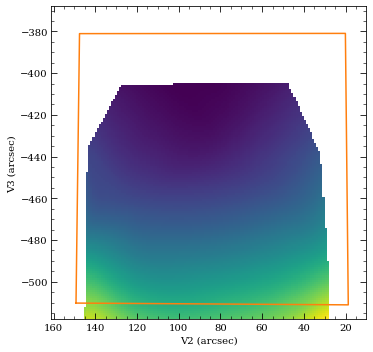

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

zmin, zmax = np.nanmin(zgrid), np.nanmax(zgrid)
extent = np.array([xgrid.min(),xgrid.max(),ygrid.min(),ygrid.max()]) * 60
ax.imshow(zgrid, extent=extent, vmin=zmin, vmax=zmax)

siaf = Siaf('NIRCam')
ap = siaf['NRCA5_FULL_MASK430R']
ap.plot(ax=ax, fill=False, color='C1')

fig.tight_layout()

# Extrapolate using RegularGridInterpolator

In [9]:
# To extrapolate outside the measured field points, we proceed 
# in two steps.  This first creates a fine-meshed cubic fit 
# over the known field points, fixes any NaN's using 
# RegularGridInterpolator, then again uses  RegularGridInterpolator 
# on the fixed data to extrapolate the requested field point.

# In principle, the first call of RegularGridInterpolator can be 
# used to extrapolate the requested field point to eliminate 
# the intermediate step, but this method enables use of all the 
# real data rather than the trimmed data set.

def _fix_zgrid_NaNs(xgrid, ygrid, zgrid_input, rot_ang=0):
    """Fix NaN's in Zernike Grid
    
    We trim NaN's within `zgrid`, then generate an extrapolation function
    using `RegularGridInterpolator`. A rotation angle can also be specified
    to maximize the number of remaining data points due to irregular
    polygons of the real `zgrid` data.
    
    Returns `zgrid` with the NaN's fixed using the extrapolation function.
    
    Parameter
    =========
    xgrid : ndarray
        1D V2 regular grid information
    ygrid : ndarray
        1D V3 regular grid information
    zgrid : ndarray
        2D Zernike grid
    rot_ang : float
        Option to rotate grid data for more optimal
        trimming of NaN's.
    """
            
    # Prevent this function from replacing original data
    zgrid = zgrid_input.copy()
        
    # Rotate zgrid
    if rot_ang != 0:
        zgrid = rotate(zgrid, rot_ang, reshape=False, order=1, cval=np.nan)
        
    # There will be some NaN's along the border that need to be replaced
    ind_nan = np.isnan(zgrid)
    # Remove rows/cols with NaN's
    xgrid2, ygrid2, zgrid2 = _trim_nan_image(xgrid, ygrid, zgrid)
    
    # Create regular grid interpolator function for extrapolation of NaN's
    func = RegularGridInterpolator((ygrid2,xgrid2), zgrid2, method='linear',
                                   bounds_error=False, fill_value=None)

    # Replace NaNs
    X, Y = np.meshgrid(xgrid,ygrid)
    pts = np.array([Y[ind_nan], X[ind_nan]]).transpose()
    zgrid[ind_nan] = func(pts)

    # De-rotate clipped zgrid image and redo RegularGridInterpolator
    if rot_ang != 0:
        # De-rotate
        zgrid = rotate(zgrid, -rot_ang, reshape=False, order=1, cval=np.nan)
        # There will be some NaNs along the border that need to be replaced
        ind_nan = np.isnan(zgrid)
        # Remove rows/cols 1 by 1 until no NaNs
        xgrid2, ygrid2, zgrid2 = _trim_nan_image(xgrid, ygrid, zgrid)

        # Create regular grid interpolator function for extrapolation of NaN's
        func = RegularGridInterpolator((ygrid2,xgrid2), zgrid2, method='linear',
                                       bounds_error=False, fill_value=None)

        # Replace NaNs
        pts = np.array([Y[ind_nan], X[ind_nan]]).transpose()
        zgrid[ind_nan] = func(pts)
        
    return zgrid

def _trim_nan_image(xgrid, ygrid, zgrid):
    """NaN Trimming of Image
    
    Remove rows/cols with NaN's while trying to preserve
    the maximum footprint of real data.
    """
    
    xgrid2, ygrid2, zgrid2 = xgrid, ygrid, zgrid
    
    # Create a mask of NaN'ed values
    nan_mask = np.isnan(zgrid2)
    nrows, ncols = nan_mask.shape
    # Determine number of NaN's along each row and col
    num_nans_cols = nan_mask.sum(axis=0)
    num_nans_rows = nan_mask.sum(axis=1)
    
    # First, crop all rows/cols that are only NaN's
    xind_good = np.where(num_nans_cols < nrows)[0]
    yind_good = np.where(num_nans_rows < ncols)[0]
    # get border limits
    x1, x2 = (xind_good.min(), xind_good.max()+1)
    y1, y2 = (yind_good.min(), yind_good.max()+1)
    # Trim of NaN borders
    xgrid2 = xgrid2[x1:x2]
    ygrid2 = ygrid2[y1:y2]
    zgrid2 = zgrid2[y1:y2,x1:x2]
    
    # Find a optimal rectangule subsection free of NaN's
    # Iterative cropping
    ndiff = 5
    while np.isnan(zgrid2.sum()):
        # Make sure ndiff is not negative
        if ndiff<0:
            break

        npix = zgrid2.size

        # Create a mask of NaN'ed values
        nan_mask = np.isnan(zgrid2)
        nrows, ncols = nan_mask.shape
        # Determine number of NaN's along each row and col
        num_nans_cols = nan_mask.sum(axis=0)
        num_nans_rows = nan_mask.sum(axis=1)

        # Look for any appreciable diff row-to-row/col-to-col
        col_diff = num_nans_cols - np.roll(num_nans_cols,-1) 
        row_diff = num_nans_rows - np.roll(num_nans_rows,-1)
        # For edge wrapping, just use last minus previous
        col_diff[-1] = col_diff[-2]
        row_diff[-1] = row_diff[-2]
        
        #print(npix, zgrid2.shape, num_nans_cols, num_nans_rows)

        # Keep rows/cols composed mostly of real data 
        # and where number of NaN's don't change dramatically
        xind_good = np.where( ( np.abs(col_diff) <= ndiff  ) & 
                              ( num_nans_cols < 0.5*nrows ) )[0]
        yind_good = np.where( ( np.abs(row_diff) <= ndiff  ) & 
                              ( num_nans_rows < 0.5*ncols ) )[0]
        # get border limits
        x1, x2 = (xind_good.min(), xind_good.max()+1)
        y1, y2 = (yind_good.min(), yind_good.max()+1)
    
        # Trim of NaN borders
        xgrid2 = xgrid2[x1:x2]
        ygrid2 = ygrid2[y1:y2]
        zgrid2 = zgrid2[y1:y2,x1:x2]
        
        # Check for convergence
        # If we've converged, reduce 
        if npix==zgrid2.size:
            ndiff -= 1
                
    # Last ditch effort in case there are still NaNs
    # If so, remove rows/cols 1 by 1 until no NaNs
    while np.isnan(zgrid2.sum()):
        xgrid2 = xgrid2[1:-1]
        ygrid2 = ygrid2[1:-1]
        zgrid2 = zgrid2[1:-1,1:-1]
            
    return xgrid2, ygrid2, zgrid2



In [10]:
# Fix NaN's via extrapolation
zgrid_fix = _fix_zgrid_NaNs(xgrid, ygrid, zgrid)

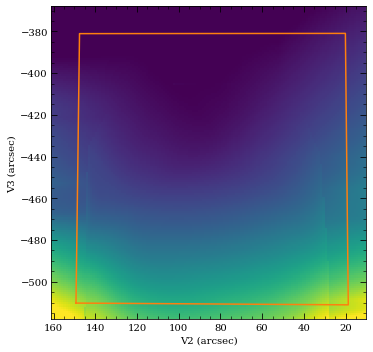

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

#zmin, zmax = np.nanmin(zgrid), np.nanmax(zgrid)
extent = np.array([xgrid.min(),xgrid.max(),ygrid.min(),ygrid.max()]) * 60
ax.imshow(zgrid_fix, extent=extent, vmin=zmin, vmax=zmax)

siaf = Siaf('NIRCam')
ap = siaf['NRCA5_FULL_MASK430R']
ap.plot(ax=ax, fill=False, color='C1')

fig.tight_layout()

# Do All Apertures

In [12]:
# for mod in ['SW', 'LW', 'SWA', 'LWA', 'SWB', 'LWB']:
for mod in ['SWA', 'LWA', 'SWB', 'LWB']:
    # Create a Zernike cube
    zcube = []
    for k in zkeys:
        xgrid, ygrid, zgrid = gen_cv3_zgrid(ztable_full, v2v3_limits, mod, k)
        zgrid_fix = _fix_zgrid_NaNs(xgrid, ygrid, zgrid)
        zcube.append(zgrid_fix)
        
    zube = np.array(zcube)
    
    hdu = fits.PrimaryHDU(zcube)
    hdr = hdu.header

    dstep = 1. / 60.
    hdr['units'] = 'meters'
    hdr['xunits'] = 'Arcmin'
    hdr['xmin'] = xgrid.min()
    hdr['xmax'] = xgrid.max()
    hdr['xdel'] = dstep
    hdr['yunits'] = 'Arcmin'
    hdr['ymin'] = ygrid.min()
    hdr['ymax'] = ygrid.max()
    hdr['ydel'] = dstep

    hdr['wave'] = 2.10 if 'SW' in mod else 3.23

    hdr['comment'] = 'X and Y values correspond to V2 and V3 coordinates (arcmin).'
    hdr['comment'] = 'Slices in the cube correspond to Zernikes 1 to 36.'
    hdr['comment'] = 'Zernike values calculated using 2D cubic interpolation'
    hdr['comment'] = 'and linear extrapolation outside gridded data.'

    fname = 'NIRCam{}_zernikes_coron.fits'.format(mod)
    hdu.writeto(outdir + fname, overwrite=True)
